# Generates images from text prompts with CLIP guided diffusion.

It uses OpenAI's 256x256 unconditional ImageNet diffusion model (https://github.com/openai/guided-diffusion) together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images.

In [1]:
# Check the GPU status

!nvidia-smi

Sun Apr 14 02:48:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install dependencies

!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/guided-diffusion
!pip install -e ./CLIP
!pip install -e ./guided-diffusion
!pip install lpips

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 2 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 10.43 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Cloning into 'guided-diffusion'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 111 (delta 1), reused 4 (delta 1), pack-reused 102
Receiving objects: 100% (111/111), 72.39 KiB | 1.37 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Obtaining file:///content/CLIP
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 636.6 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cac

In [3]:
# Download the diffusion model

!curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2108M  100 2108M    0     0  52.0M      0  0:00:40  0:00:40 --:--:-- 62.0M


In [4]:
# Imports

import gc
import io
import math
import sys

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

In [5]:
# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

In [ ]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        # If the input is a URL, fetch the content
        r = requests.get(url_or_path)
        r.raise_for_status()  # Raise an exception for HTTP errors
        fd = io.BytesIO()
        fd.write(r.content)  # Write the content to a BytesIO buffer
        fd.seek(0)  # Set the buffer position to the beginning
        return fd  # Return the buffer
    else:
        # If the input is a local file path, open the file in binary read mode
        return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        # If the prompt starts with 'http://' or 'https://', split it by ':'
        vals = prompt.rsplit(':', 2)
        # Ensure there are at least two elements in vals, append empty strings if not
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        # If the prompt does not start with 'http://' or 'https://', split it by ':'
        vals = prompt.rsplit(':', 1)
        # Ensure there are at least two elements in vals, append '1' if not
        vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size  # Size of the output cutouts
        self.cutn = cutn  # Number of cutouts to generate
        self.cut_pow = cut_pow  # Scaling factor for controlling the size of the cutouts

    def forward(self, input):
        sideY, sideX = input.shape[2:4]  # Get the height and width of the input tensor
        max_size = min(sideX, sideY)  # Calculate the maximum size for cutouts
        min_size = min(sideX, sideY, self.cut_size)  # Calculate the minimum size for cutouts
        cutouts = []  # List to store generated cutouts
        for _ in range(self.cutn):
            # Randomly select a size for the cutout based on cut_pow
            size = int(torch.rand([]) ** self.cut_pow * (max_size - min_size) + min_size)
            # Randomly select offsets for the cutout
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            # Extract the cutout from the input tensor
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # Resize the cutout to cut_size using adaptive average pooling
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    # Normalize x and y along the last dimension
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    # Compute the spherical distance loss
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    # Pad the input tensor
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    # Compute differences along x and y axes
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    # Compute the mean of squared differences
    return (x_diff ** 2 + y_diff ** 2).mean([1, 2, 3])


def range_loss(input):
    # Compute the mean squared error between input and its clamped version
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])


In [6]:
# Model settings

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '1000',  # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [7]:
# Load models
# sets up the required models for image generation, including the diffusion model, CLIP model, and LPIPS model, and ensures they are properly loaded and prepared for inference on the chosen device.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config) # model represents the generative model, and diffusion represents the diffusion process used in the generation.
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu')) # The pre-trained weights for the diffusion model are loaded from the file '256x256_diffusion_uncond.pt'.
model.requires_grad_(False).eval().to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

# The CLIP (Contrastive Language-Image Pre-training) model is loaded. In this case, it's the Vision Transformer (ViT) with the 'B' variant and an input resolution of 16 tokens.
# The model is set to evaluation mode, and its gradients are turned off.
clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)


Using device: cuda:0


100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 95.3MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 116MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


## Settings for this run:

In [8]:
prompts = ['alien running on water']
image_prompts = []
batch_size = 1
clip_guidance_scale = 1000  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
range_scale = 50            # Controls how far out of range RGB values are allowed to be.
cutn = 16
n_batches = 1
init_image = None   # This can be an URL or Colab local path and must be in quotes.
skip_timesteps = 0  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
init_scale = 0      # This enhances the effect of the init image, a good value is 1000.
seed = 0

### Actually do the run...

  0%|          | 0/1000 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


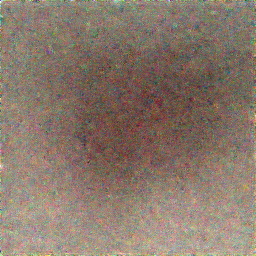


Batch 0, step 100, output 0:


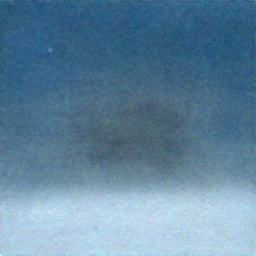


Batch 0, step 200, output 0:


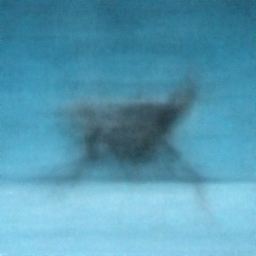


Batch 0, step 300, output 0:


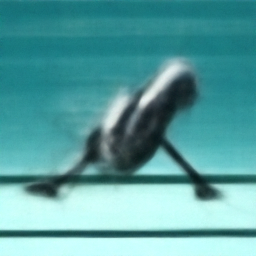


Batch 0, step 400, output 0:


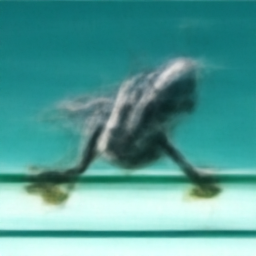


Batch 0, step 500, output 0:


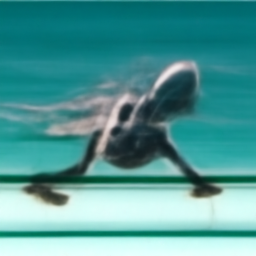


Batch 0, step 600, output 0:


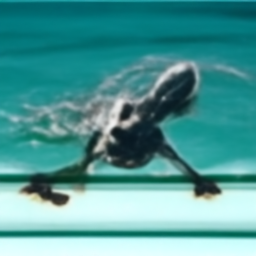


Batch 0, step 700, output 0:


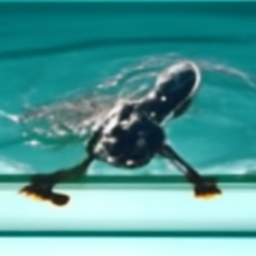


Batch 0, step 800, output 0:


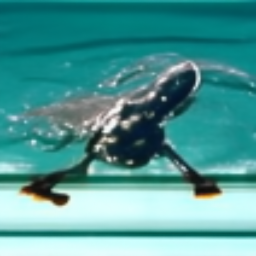


Batch 0, step 900, output 0:


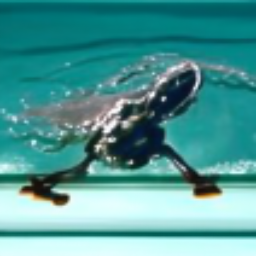


Batch 0, step 999, output 0:


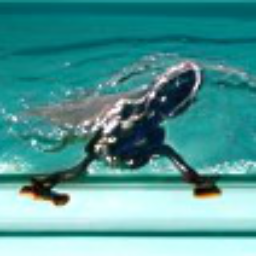

In [9]:
def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float()
        dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
        dists = dists.view([cutn, n, -1])
        losses = dists.mul(weights).sum(2).mean(0)
        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
            cond_fn_with_grad=True,
        )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))

gc.collect()
do_run()

In [10]:
prompts = ['sun rising behind the mountains']
image_prompts = []
batch_size = 1
clip_guidance_scale = 1000  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
range_scale = 50            # Controls how far out of range RGB values are allowed to be.
cutn = 16
n_batches = 1
init_image = None   # This can be an URL or Colab local path and must be in quotes.
skip_timesteps = 0  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
init_scale = 0      # This enhances the effect of the init image, a good value is 1000.
seed = 0

  0%|          | 0/1000 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


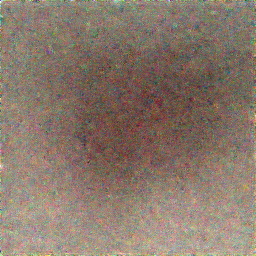


Batch 0, step 100, output 0:


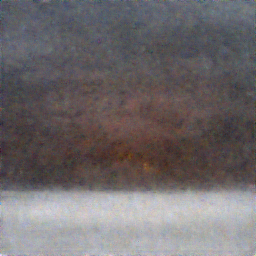


Batch 0, step 200, output 0:


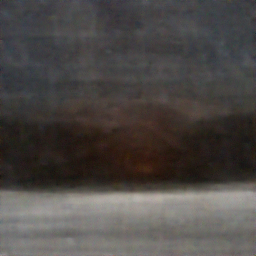


Batch 0, step 300, output 0:


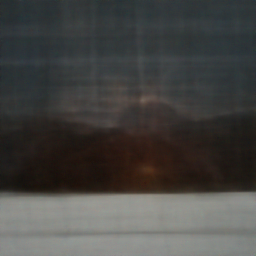


Batch 0, step 400, output 0:


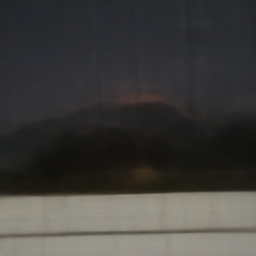


Batch 0, step 500, output 0:


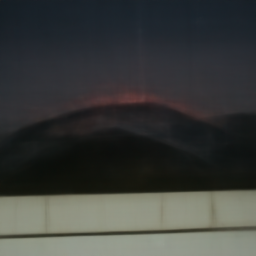


Batch 0, step 600, output 0:


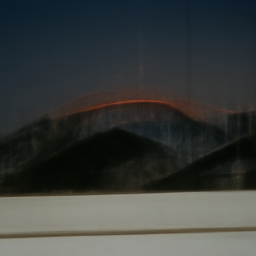


Batch 0, step 700, output 0:


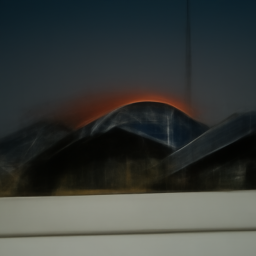


Batch 0, step 800, output 0:


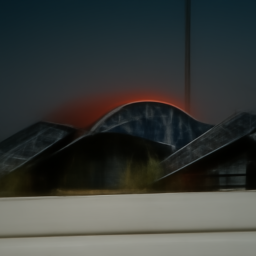


Batch 0, step 900, output 0:


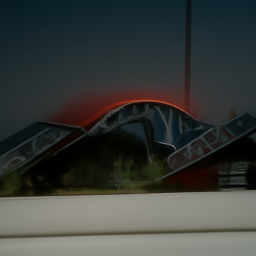


Batch 0, step 999, output 0:


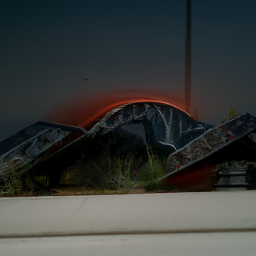

In [11]:
def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float()
        dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
        dists = dists.view([cutn, n, -1])
        losses = dists.mul(weights).sum(2).mean(0)
        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
            cond_fn_with_grad=True,
        )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))

gc.collect()
do_run()